In [1]:
!pip install opencv-python

## 테스트 데이터셋 로드

In [2]:
import os
import urllib.request
import tarfile
import pickle
import numpy as np
from common.ResNet20 import ResNet20
from common.functions import softmax 

def download_cifar100(save_path='cifar-100-python'):
    if os.path.exists(save_path):
        print("CIFAR-100 이미 존재")
        return

    url = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    filename = 'cifar-100-python.tar.gz'
    print("CIFAR-100 다운로드 중...")
    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
    os.remove(filename)
    print("다운로드 완료")

def load_batch(filepath):
    with open(filepath, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    data = data_dict[b'data']
    fine_labels = np.array(data_dict[b'fine_labels'])
    coarse_labels = np.array(data_dict[b'coarse_labels'])
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    return data, fine_labels, coarse_labels

In [3]:
def load_cifar100_full(data_dir='./cifar-100-python', valid_ratio=0.1):
    # 1. Load train and test batch
    x_train_all, y_train_fine_all, y_train_coarse_all = load_batch(os.path.join(data_dir, 'train'))
    x_test, y_test_fine, y_test_coarse = load_batch(os.path.join(data_dir, 'test'))

    # 2. Split train → train + validation
    num_total = x_train_all.shape[0]
    num_valid = int(num_total * valid_ratio)

    x_valid = x_train_all[:num_valid]
    t_valid_fine = y_train_fine_all[:num_valid]
    t_valid_coarse = y_train_coarse_all[:num_valid]

    x_train = x_train_all[num_valid:]
    t_train_fine = y_train_fine_all[num_valid:]
    t_train_coarse = y_train_coarse_all[num_valid:]

    # 3. Return all
    return (x_train, x_valid, x_test,
            t_train_coarse, t_valid_coarse, y_test_coarse,
            t_train_fine, t_valid_fine, y_test_fine)

In [4]:
# CIFAR-100 다운로드
download_cifar100()

# 전체 데이터셋 로드
(x_train, x_valid, x_test,
 t_train_coarse, t_valid_coarse, t_test_coarse,
 t_train_fine, t_valid_fine, t_test_fine) = load_cifar100_full()

# 확인 출력
print("CIFAR-100 데이터셋 로드 완료:")
print(" - x_train:", x_train.shape)
print(" - x_valid:", x_valid.shape)
print(" - x_test :", x_test.shape)
print(" - t_train_fine :", t_train_fine.shape)
print(" - t_valid_fine :", t_valid_fine.shape)
print(" - t_test_fine  :", t_test_fine.shape)
print(" - t_train_coarse:", t_train_coarse.shape)
print(" - t_valid_coarse:", t_valid_coarse.shape)
print(" - t_test_coarse :", t_test_coarse.shape)


CIFAR-100 이미 존재
CIFAR-100 데이터셋 로드 완료:
 - x_train: (45000, 3, 32, 32)
 - x_valid: (5000, 3, 32, 32)
 - x_test : (10000, 3, 32, 32)
 - t_train_fine : (45000,)
 - t_valid_fine : (5000,)
 - t_test_fine  : (10000,)
 - t_train_coarse: (45000,)
 - t_valid_coarse: (5000,)
 - t_test_coarse : (10000,)


## 모델 관리 함수

In [5]:
##miniVGG 파라미터 불러오기
def restore_model_parameters(model, model_state):
    for name in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc1', 'fc2']:
        layer = getattr(model, name)
        layer.W[...] = model_state[f'{name}_W']
        layer.b[...] = model_state[f'{name}_b']


def restore_bn_parameters(model, bn_state):
    for i, name in enumerate(['bn1', 'bn2', 'bn3', 'bn4', 'bn5']):
        bn = getattr(model, name)
        bn.gamma        = bn_state[f'bn{i}_gamma'].copy()
        bn.beta         = bn_state[f'bn{i}_beta'].copy()
        bn.running_mean = bn_state[f'bn{i}_running_mean'].copy()
        bn.running_var  = bn_state[f'bn{i}_running_var'].copy()

In [7]:
from common.MiniVGGNet import MiniVGGNet
import pickle
import numpy as np


model = MiniVGGNet()

with open("final/MiniVGGNet_final_ex2_finetune3_epoch16.pkl", "rb") as f:
    checkpoint = pickle.load(f)
    model_state = checkpoint["model"]
    bn_state = checkpoint["bn"]

# 3. BN 파라미터 복원
restore_bn_parameters(model, bn_state)
restore_model_parameters(model, model_state)

for i in range(0, x_train.shape[0], 128):
    x_batch = x_train[i:i+128]
    _ = model.forward(x_batch, train_flg=True)  # running_mean/var 갱신용


model_name="(miniVGGNet_final)"
        

In [8]:
#evaluate 함수 정의, softmax 출력 함수, 모델별 데이터 전처리
def evaluate_model(model, x, y_true):
    batch_size = 100
    preds = []
    for i in range(0, x.shape[0], batch_size):
        x_batch = x[i:i+batch_size]
        logits = model.predict(x_batch)
        probs = softmax(logits)
        y_pred = np.argmax(probs, axis=1)
        preds.append(y_pred)
    preds = np.concatenate(preds)
    acc = np.sum(preds == y_true) / len(y_true)
    return preds, acc

In [9]:
fine_preds, fine_acc = evaluate_model(model, x_train, t_train_fine)
print(f"[🎯 Fine Label] Train Accuracy: {fine_acc:.4f}")

[🎯 Fine Label] Train Accuracy: 0.5878


In [10]:
fine_valid_preds, fine_valid_acc = evaluate_model(model, x_valid, t_valid_fine)
print(f"[🎯 Fine Label] Valid Accuracy: {fine_valid_acc:.4f}")

[🎯 Fine Label] Valid Accuracy: 0.5750


In [11]:
fine_test_preds, fine_test_acc = evaluate_model(model, x_test, t_test_fine)
print(f"[🎯 Fine Label] Test Accuracy: {fine_test_acc:.4f}")

[🎯 Fine Label] Test Accuracy: 0.3796


## 시각화 함수

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def balanced_sample(labels, per_class=30, num_classes=100, random_state=42):
    np.random.seed(random_state)
    indices = []
    for i in range(num_classes):
        idx = np.where(labels == i)[0]
        if len(idx) < per_class:
            continue
        selected = np.random.choice(idx, size=per_class, replace=False)
        indices.extend(selected)
    return np.array(indices)

    
def plot_tsne_coarse(val_logits, pred_coarse, title="t-SNE (Coarse)", mapping_name=None, perplexity=30, save_path=None):
    """
    coarse label 기반 t-SNE 시각화 함수
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    features_2d = tsne.fit_transform(val_logits)

    df = pd.DataFrame({
        "x": features_2d[:, 0],
        "y": features_2d[:, 1],
        "label": pred_coarse
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        palette="tab20",
        data=df,
        s=30, alpha=0.7
    )

    if mapping_name:
        plt.title(f"{title} - {mapping_name}")
    else:
        plt.title(title)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, title="Coarse Class", fontsize="small")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()



def plot_tsne_fine(val_logits, fine_labels, title="Fine Class Embedding", perplexity=30, random_state=42, save_path=None):
    """
    100개 fine class 기준 t-SNE 시각화
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    features_2d = tsne.fit_transform(val_logits)

    base_colors = sns.color_palette("tab20", 20)
    full_colors = base_colors * 5
    color_map = {i: full_colors[i] for i in range(100)}
    markers = ['o', 's', 'D', '^', 'X']
    marker_map = {i: markers[i // 20] for i in range(100)}

    df = pd.DataFrame({
        "x": features_2d[:, 0],
        "y": features_2d[:, 1],
        "label": fine_labels
    })

    plt.figure(figsize=(14, 12))
    for i in range(100):
        subset = df[df['label'] == i]
        plt.scatter(
            subset['x'], subset['y'],
            label=str(i),
            alpha=0.6,
            s=30,
            color=color_map[i],
            marker=marker_map[i]
        )

    plt.title(title, fontsize=15)
    plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=2, title="Fine Label")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_confusion_matrix_sns(y_true, y_pred, num_classes, title, class_labels=None, normalize=False):
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes),
                          normalize='true' if normalize else None)

    annot = np.full_like(cm, "", dtype=object)
    for i in range(min(cm.shape[0], cm.shape[1])):
        val = cm[i, i]
        annot[i, i] = f"{val:.2f}" if normalize else f"{int(val)}"

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm,
                     annot=annot,
                     fmt="",  # 이미 문자열이므로 포맷 불필요
                     cmap='Blues',
                     annot_kws={'color': 'black'}) 
    

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

    tick_freq = 5
    ticks = np.arange(0, num_classes, tick_freq)
    tick_labels = [str(i) for i in ticks]  # 숫자 문자열로 변환

    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=90, fontsize=6)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels, fontsize=6)

    plt.tight_layout()
    plt.show()

## train set mapping

In [14]:
## train set
import numpy as np
from common.functions import softmax
from common.coarse_mapping import get_cifar100_fine_to_coarse_dict, CoarseMapper, compute_coarse_accuracy, compute_fine_class_accuracy

# 1. fine → coarse 매핑 딕셔너리 및 매퍼 클래스 준비
f2c = get_cifar100_fine_to_coarse_dict()
mapper = CoarseMapper(f2c)

# 2. 모델 출력 얻기
train_logits = model.predict(x_train)          # (N, 100)
fine_probs = softmax(train_logits)             # (N, 100)
fine_preds = np.argmax(fine_probs, axis=1)

# 3. 정답 coarse label 변환
true_coarse_train = np.array([f2c[f] for f in t_train_fine])

# 4. 각 방식별 coarse 예측 및 정확도 계산
# 방식 1: Argmax 기반
pred_coarse_1 = mapper.argmax_mapping(fine_probs)
acc1 = compute_coarse_accuracy(pred_coarse_1, true_coarse_train)
print(f"[🎯 방식 1 - Argmax Mapping]     Coarse Accuracy: {acc1:.4f}")

# 방식 2: Entropy Weighted Mapping
pred_coarse_2 = mapper.entropy_weighted_mapping(fine_probs)
acc2 = compute_coarse_accuracy(pred_coarse_2, true_coarse_train)
print(f"[🔍 방식 2 - Entropy Weighted]   Coarse Accuracy: {acc2:.4f}")

# 방식 3: Soft Average Mapping
pred_coarse_3 = mapper.soft_average_mapping(fine_probs)
acc3 = compute_coarse_accuracy(pred_coarse_3, true_coarse_train)
print(f"[🧪 방식 3 - Soft Average]        Coarse Accuracy: {acc3:.4f}")

# 방식 4: Validation Guided Mapping
# fine class별 accuracy 기반 가중치 구하기
fine_weights = compute_fine_class_accuracy(fine_preds, t_train_fine)
pred_coarse_4 = mapper.validation_guided_mapping(fine_probs, fine_weights)
acc4= compute_coarse_accuracy(pred_coarse_4, true_coarse_train)
print(f"[📊 방식 4 - Validation Guided]  Coarse Accuracy: {acc4:.4f}")



[🎯 방식 1 - Argmax Mapping]     Coarse Accuracy: 0.6736
[🔍 방식 2 - Entropy Weighted]   Coarse Accuracy: 0.6808
[🧪 방식 3 - Soft Average]        Coarse Accuracy: 0.6808
[📊 방식 4 - Validation Guided]  Coarse Accuracy: 0.6776


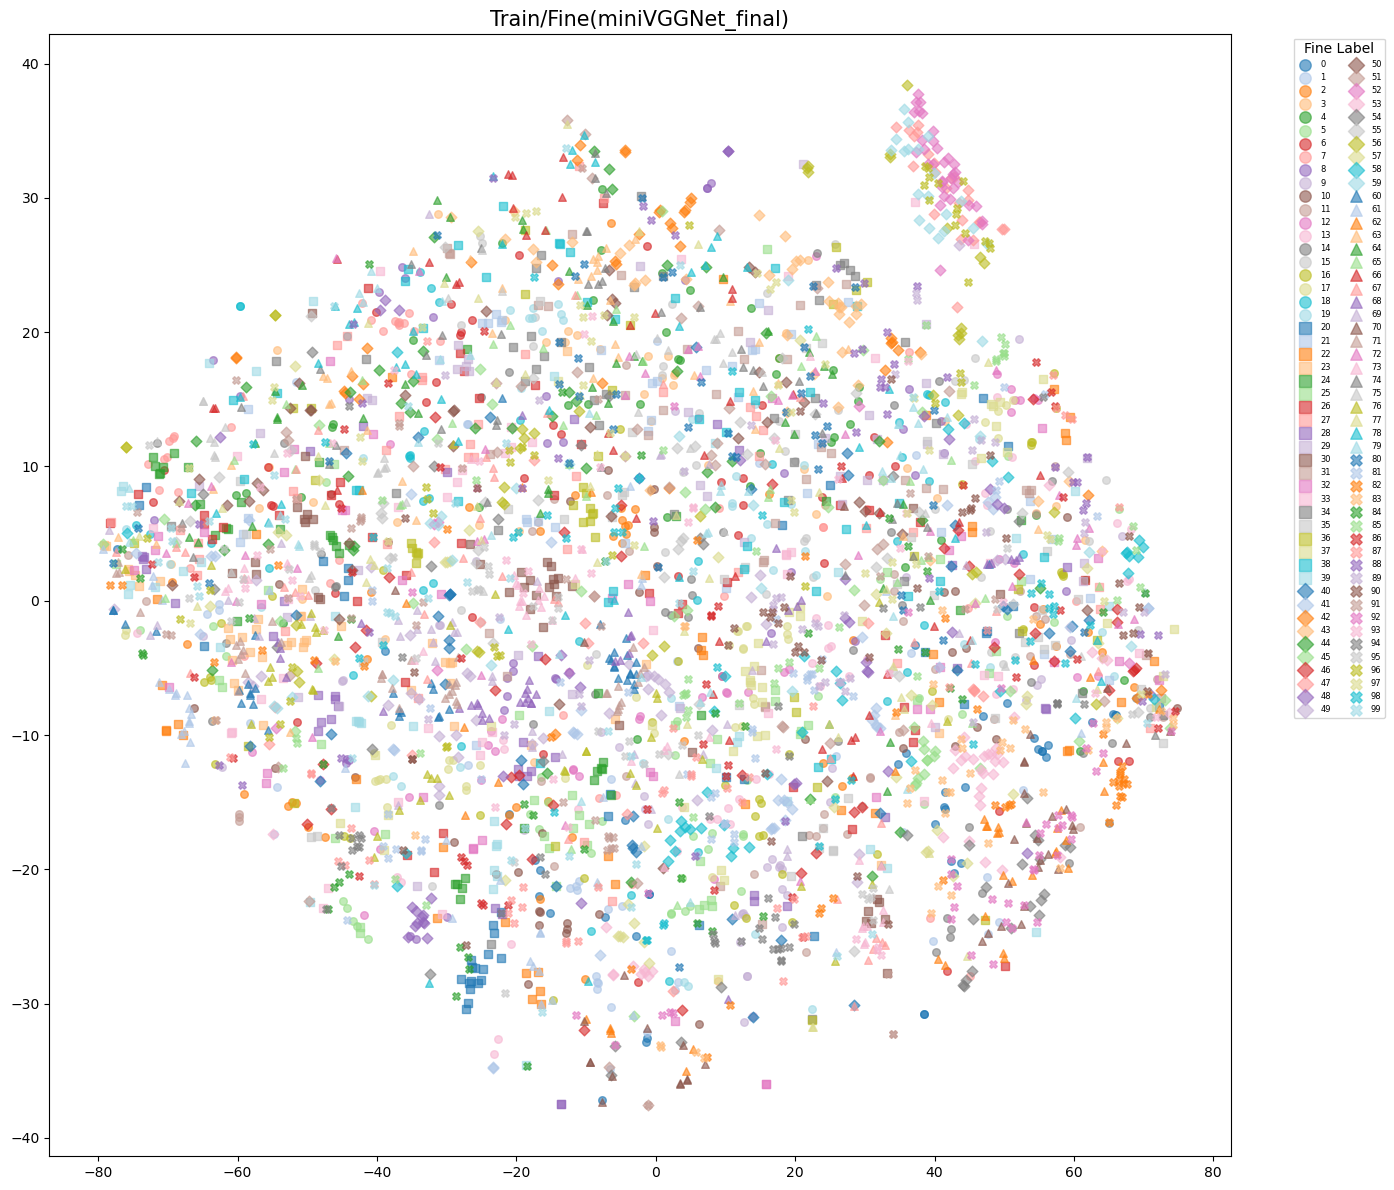

In [15]:
## fine tsne 샘플링, plot

idx = balanced_sample(t_train_fine, per_class=40)
plot_tsne_fine(train_logits[idx], t_train_fine[idx], title="Train/Fine"+model_name)

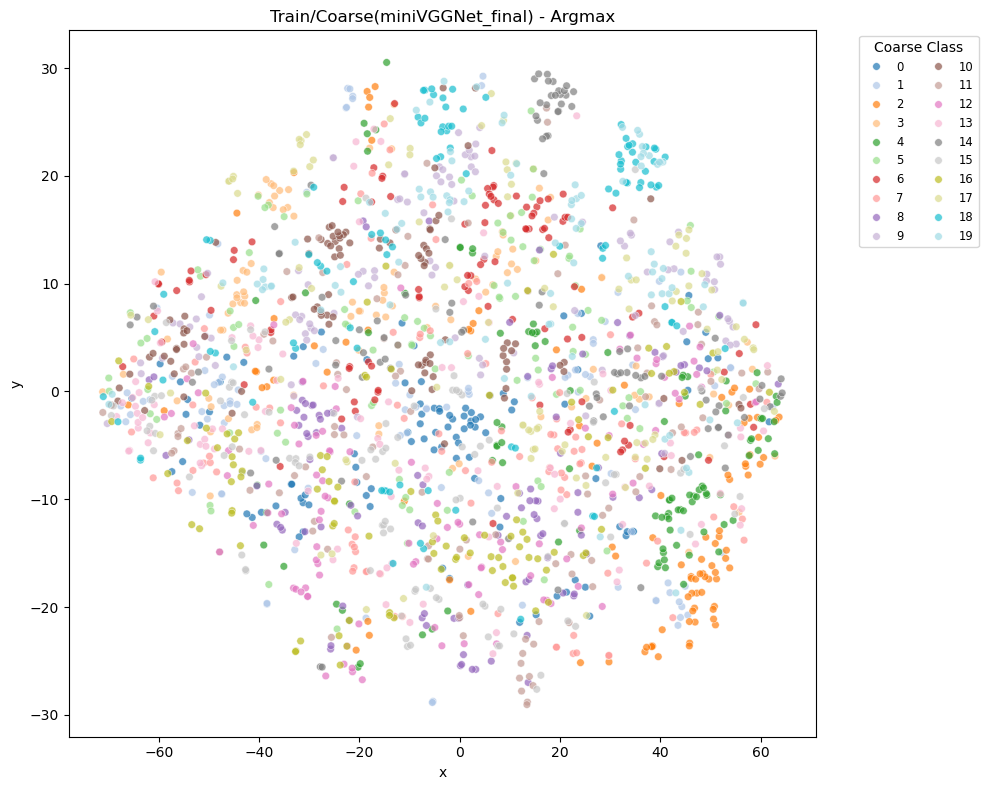

'\n\nidx2 = balanced_sample(pred_coarse_2, per_class=100, num_classes=20)\nplot_tsne_coarse(train_logits[idx2], pred_coarse_2[idx2], title="Train/Coarse"+model_name, mapping_name="Entropy Weighted")\n\nidx3 = balanced_sample(pred_coarse_3, per_class=100, num_classes=20)\nplot_tsne_coarse(train_logits[idx3], pred_coarse_3[idx3], title="Train/Coarse"+model_name, mapping_name="Soft Average")\n\nidx4 = balanced_sample(pred_coarse_4, per_class=100, num_classes=20)\nplot_tsne_coarse(train_logits[idx4], pred_coarse_4[idx4], title="Train/Coarse"+model_name, mapping_name="Validation Guided")\n'

In [16]:
## coarse tsne 샘플링, plot
idx1 = balanced_sample(pred_coarse_1, per_class=100, num_classes=20)
plot_tsne_coarse(train_logits[idx1], pred_coarse_1[idx1], title="Train/Coarse"+model_name, mapping_name="Argmax")

'''

idx2 = balanced_sample(pred_coarse_2, per_class=100, num_classes=20)
plot_tsne_coarse(train_logits[idx2], pred_coarse_2[idx2], title="Train/Coarse"+model_name, mapping_name="Entropy Weighted")

idx3 = balanced_sample(pred_coarse_3, per_class=100, num_classes=20)
plot_tsne_coarse(train_logits[idx3], pred_coarse_3[idx3], title="Train/Coarse"+model_name, mapping_name="Soft Average")

idx4 = balanced_sample(pred_coarse_4, per_class=100, num_classes=20)
plot_tsne_coarse(train_logits[idx4], pred_coarse_4[idx4], title="Train/Coarse"+model_name, mapping_name="Validation Guided")
'''

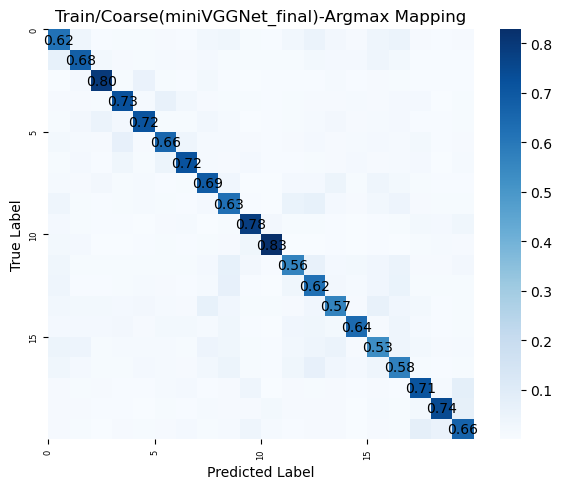

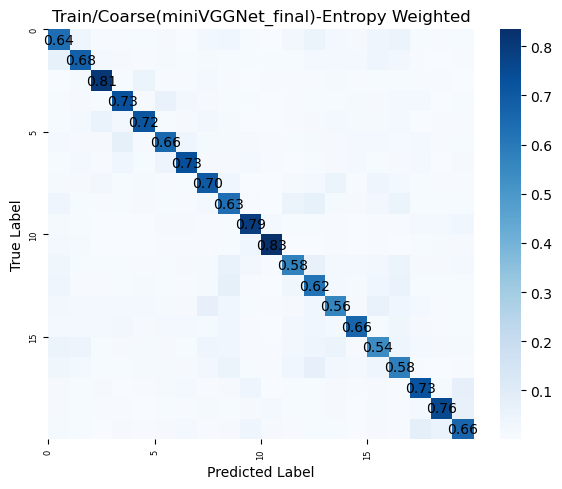

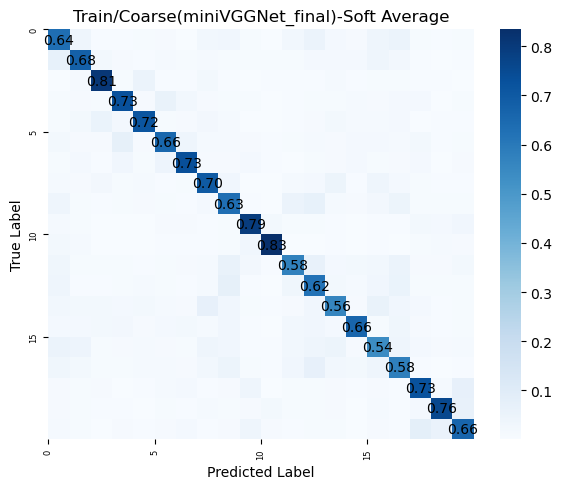

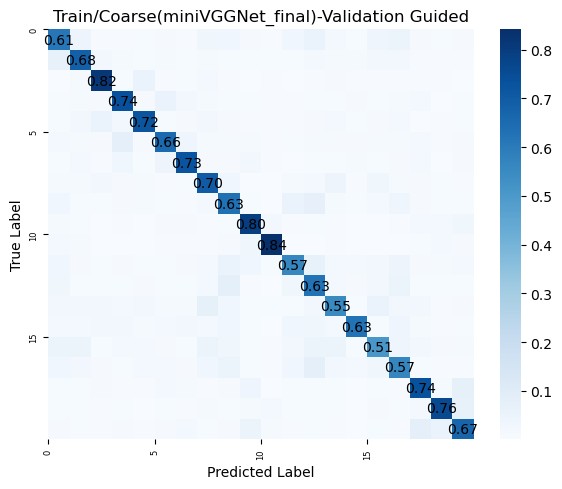

In [17]:
plot_confusion_matrix_sns(true_coarse_train, pred_coarse_1, 20, "Train/Coarse"+model_name+"-Argmax Mapping", normalize=True)
plot_confusion_matrix_sns(true_coarse_train, pred_coarse_2, 20, "Train/Coarse"+model_name+"-Entropy Weighted", normalize=True)
plot_confusion_matrix_sns(true_coarse_train, pred_coarse_3, 20, "Train/Coarse"+model_name+"-Soft Average", normalize=True)
plot_confusion_matrix_sns(true_coarse_train, pred_coarse_4, 20, "Train/Coarse"+model_name+"-Validation Guided", normalize=True)

## valid set mapping

In [18]:
## valid set
import numpy as np
from common.functions import softmax
from common.coarse_mapping import (
    get_cifar100_fine_to_coarse_dict,
    CoarseMapper,
    compute_fine_class_accuracy,
    compute_coarse_accuracy
)

# 1. 딕셔너리 및 coarse 매퍼 초기화
f2c = get_cifar100_fine_to_coarse_dict()
mapper = CoarseMapper(f2c)

# 2. validation set 예측
val_logits = model.predict(x_valid)            # (N, 100)
val_probs = softmax(val_logits)
val_preds = np.argmax(val_probs, axis=1)
true_coarse_val = np.array([f2c[f] for f in t_valid_fine])  # 정답 coarse

# 3. fine accuracy 계산 (자체 validation용 가중치 생성)
fine_weights_val = compute_fine_class_accuracy(val_preds, t_valid_fine)  # (100,)

# 4. coarse mapping 방식별 평가

# [1] Argmax Mapping
pred_coarse_1 = mapper.argmax_mapping(val_probs)
acc1 = compute_coarse_accuracy(pred_coarse_1, true_coarse_val)
print(f"[Argmax Mapping]     Validation Coarse Accuracy: {acc1:.4f}")

# [2] Entropy Weighted Mapping
pred_coarse_2 = mapper.entropy_weighted_mapping(val_probs)
acc2 = compute_coarse_accuracy(pred_coarse_2, true_coarse_val)
print(f"[Entropy Weighted]   Validation Coarse Accuracy: {acc2:.4f}")

# [3] Soft Average Mapping
pred_coarse_3 = mapper.soft_average_mapping(val_probs)
acc3 = compute_coarse_accuracy(pred_coarse_3, true_coarse_val)
print(f"[Soft Average]        Validation Coarse Accuracy: {acc3:.4f}")

# [4] Validation Guided Mapping (val 내부에서 weight 추정)
pred_coarse_4 = mapper.validation_guided_mapping(val_probs, fine_weights_val)
acc4 = compute_coarse_accuracy(pred_coarse_4, true_coarse_val)
print(f"[Validation Guided]  Validation Coarse Accuracy: {acc4:.4f}")


[Argmax Mapping]     Validation Coarse Accuracy: 0.6678
[Entropy Weighted]   Validation Coarse Accuracy: 0.6726
[Soft Average]        Validation Coarse Accuracy: 0.6726
[Validation Guided]  Validation Coarse Accuracy: 0.6680


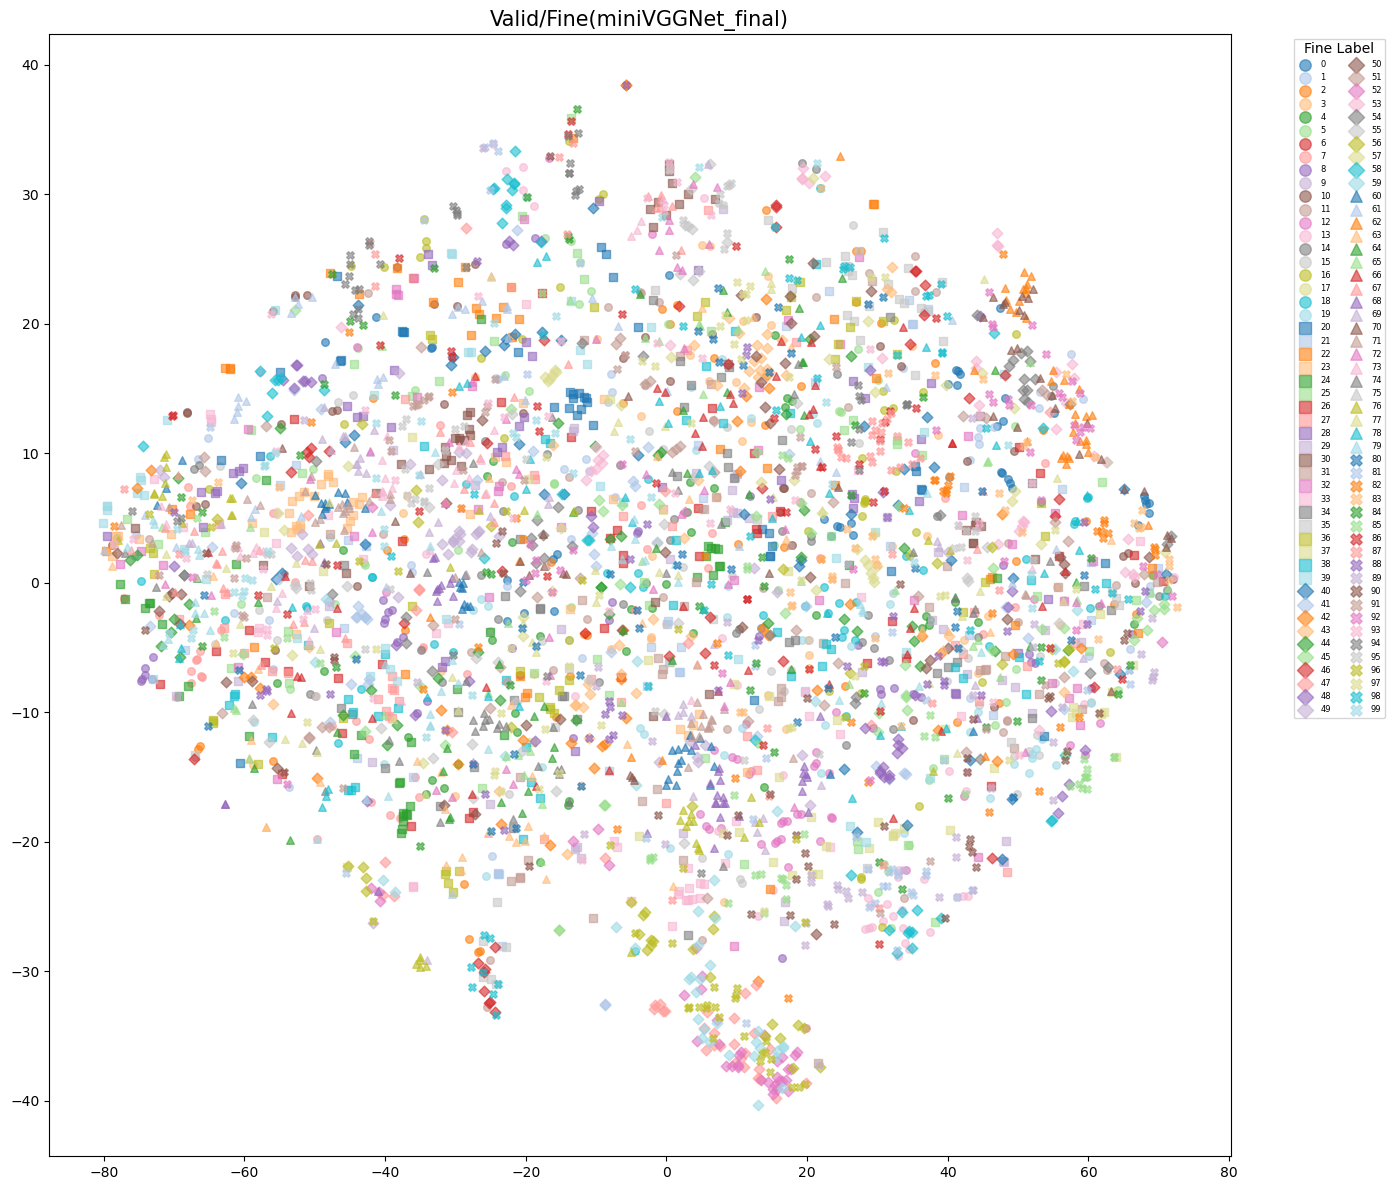

In [19]:
## fine tsne 샘플링, plot
idx = balanced_sample(t_valid_fine, per_class=40)
plot_tsne_fine(val_logits[idx], t_valid_fine[idx], title="Valid/Fine"+model_name)

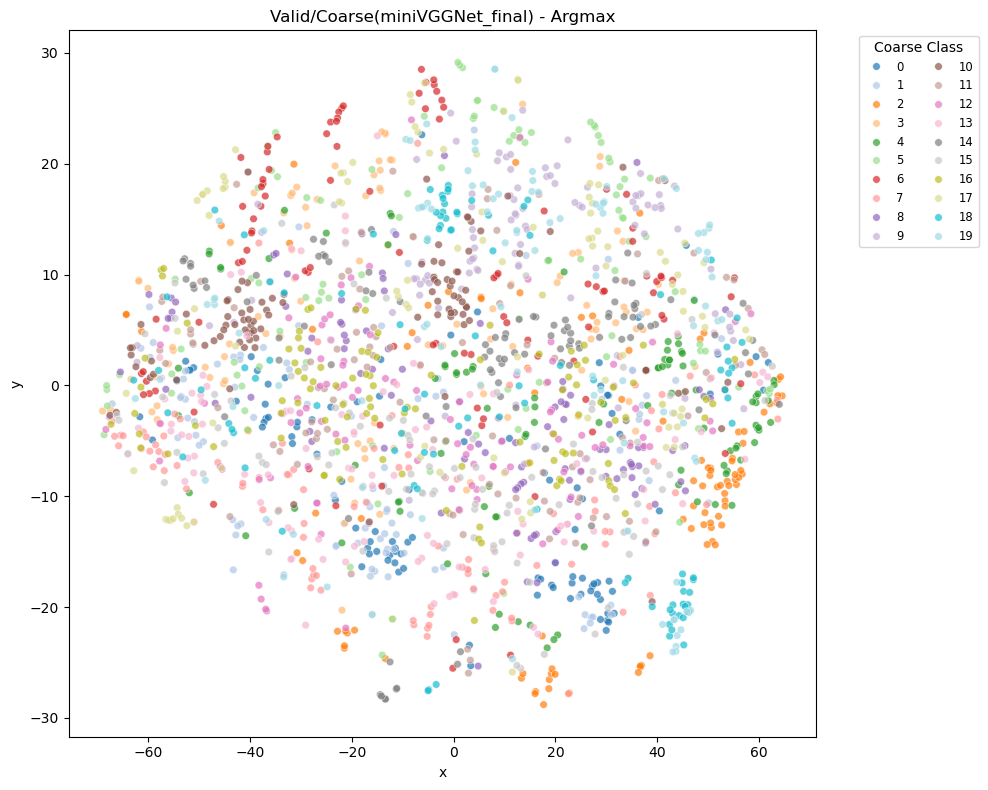

'\nidx2 = balanced_sample(pred_coarse_2, per_class=100, num_classes=20)\nplot_tsne_coarse(val_logits[idx2], pred_coarse_2[idx2], title="Valid/Coarse"+model_name, mapping_name="Entropy Weighted")\n\nidx3 = balanced_sample(pred_coarse_3, per_class=100, num_classes=20)\nplot_tsne_coarse(val_logits[idx3], pred_coarse_3[idx3], title="Valid/Coarse"+model_name, mapping_name="Soft Average")\n\nidx4 = balanced_sample(pred_coarse_4, per_class=100, num_classes=20)\nplot_tsne_coarse(val_logits[idx4], pred_coarse_4[idx4], title="Valid/Coarse"+model_name, mapping_name="Validation Guided")\n'

In [20]:
## coarse tsne 샘플링, plot
idx1 = balanced_sample(pred_coarse_1, per_class=100, num_classes=20)
plot_tsne_coarse(val_logits[idx1], pred_coarse_1[idx1], title="Valid/Coarse"+model_name, mapping_name="Argmax")

'''
idx2 = balanced_sample(pred_coarse_2, per_class=100, num_classes=20)
plot_tsne_coarse(val_logits[idx2], pred_coarse_2[idx2], title="Valid/Coarse"+model_name, mapping_name="Entropy Weighted")

idx3 = balanced_sample(pred_coarse_3, per_class=100, num_classes=20)
plot_tsne_coarse(val_logits[idx3], pred_coarse_3[idx3], title="Valid/Coarse"+model_name, mapping_name="Soft Average")

idx4 = balanced_sample(pred_coarse_4, per_class=100, num_classes=20)
plot_tsne_coarse(val_logits[idx4], pred_coarse_4[idx4], title="Valid/Coarse"+model_name, mapping_name="Validation Guided")
'''

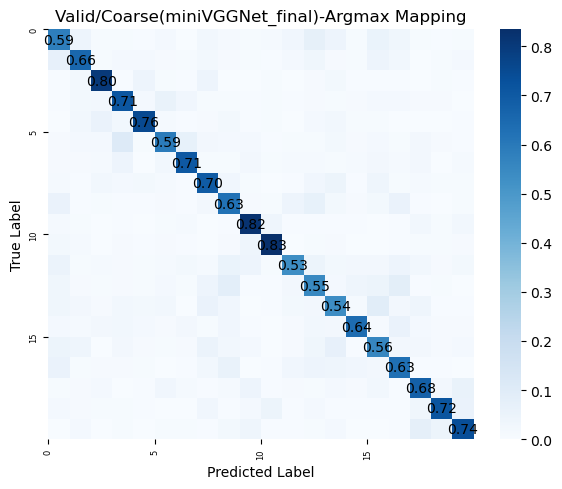

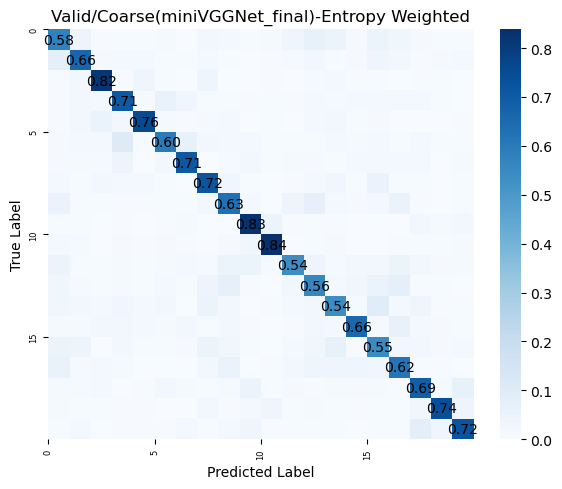

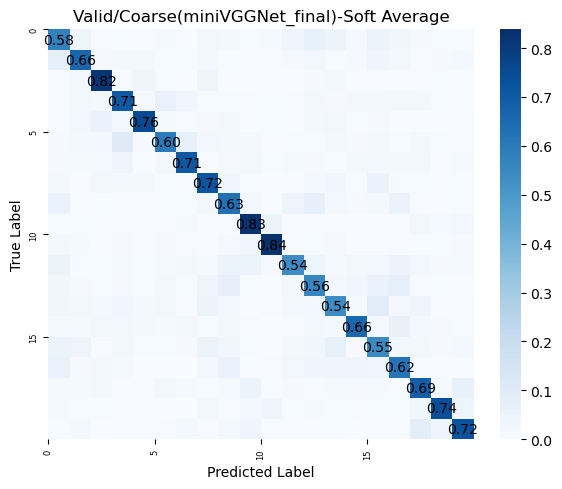

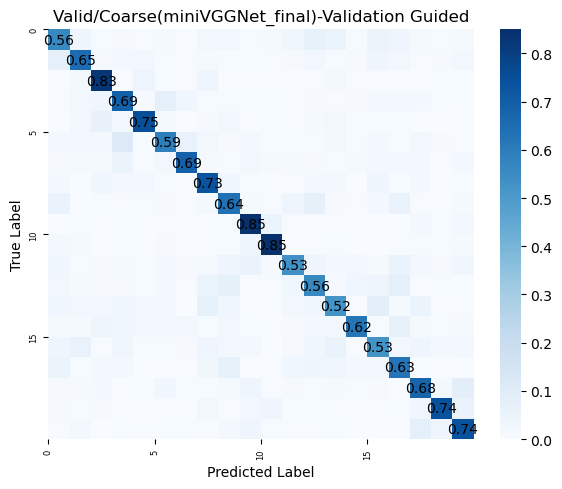

In [21]:
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_1, 20, "Valid/Coarse"+model_name+"-Argmax Mapping", normalize=True)
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_2, 20, "Valid/Coarse"+model_name+"-Entropy Weighted", normalize=True)
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_3, 20, "Valid/Coarse"+model_name+"-Soft Average", normalize=True)
plot_confusion_matrix_sns(true_coarse_val, pred_coarse_4, 20, "Valid/Coarse"+model_name+"-Validation Guided", normalize=True)

## test set mapping

In [ ]:
## test set
import numpy as np
from common.functions import softmax
from common.coarse_mapping import (
    get_cifar100_fine_to_coarse_dict,
    CoarseMapper,
    compute_fine_class_accuracy,
    compute_coarse_accuracy
)

# 1. 매핑 딕셔너리 및 매퍼 준비
f2c = get_cifar100_fine_to_coarse_dict()
mapper = CoarseMapper(f2c)

# 2. validation set으로 fine accuracy → weight 계산
val_logits = model.predict(x_valid)              # (num_val, 100)
val_probs = softmax(val_logits)
val_preds = np.argmax(val_probs, axis=1)
fine_weights = compute_fine_class_accuracy(val_preds, t_valid_fine)  # (100,)

# 3. test set 예측
test_logits = model.predict(x_test)              # (num_test, 100)
test_probs = softmax(test_logits)
test_fine_preds = np.argmax(test_probs, axis=1)
true_coarse_test = np.array([f2c[f] for f in t_test_fine])  # 정답 coarse

# 4. coarse mapping 방식별 평가
# [1] Argmax Mapping
pred_coarse_1 = mapper.argmax_mapping(test_probs)
acc1 = compute_coarse_accuracy(pred_coarse_1, true_coarse_test)
print(f"[🎯 방식 1 - Argmax Mapping]     Test Coarse Accuracy: {acc1:.4f}")

# [2] Entropy Weighted Mapping
pred_coarse_2 = mapper.entropy_weighted_mapping(test_probs)
acc2 = compute_coarse_accuracy(pred_coarse_2, true_coarse_test)
print(f"[🔍 방식 2 - Entropy Weighted]   Test Coarse Accuracy: {acc2:.4f}")

# [3] Soft Average Mapping
pred_coarse_3 = mapper.soft_average_mapping(test_probs)
acc3 = compute_coarse_accuracy(pred_coarse_3, true_coarse_test)
print(f"[🧪 방식 3 - Soft Average]        Test Coarse Accuracy: {acc3:.4f}")

# [4] Validation Guided Mapping (with val weights)
pred_coarse_4 = mapper.validation_guided_mapping(test_probs, fine_weights)
acc4 = compute_coarse_accuracy(pred_coarse_4, true_coarse_test)
print(f"[📊 방식 4 - Validation Guided]  Test Coarse Accuracy: {acc4:.4f}")


In [ ]:
## fine tsne 샘플링, plot (test set)
idx = balanced_sample(t_test_fine, per_class=30)
plot_tsne_fine(test_logits[idx], t_test_fine[idx],title="Test/Fine"+model_name)

In [ ]:
## coarse tsne 샘플링, plot (test set)
idx1 = balanced_sample(pred_coarse_1, per_class=100, num_classes=20)
plot_tsne_coarse(test_logits[idx1], pred_coarse_1[idx1],title="Test/Coarse"+model_name, mapping_name="Argmax")

''''

idx2 = balanced_sample(pred_coarse_2, per_class=100, num_classes=20)
plot_tsne_coarse(test_logits[idx2], pred_coarse_2[idx2],title="Test/Coarse"+model_name, mapping_name="Entropy Weighted")

idx3 = balanced_sample(pred_coarse_3, per_class=100, num_classes=20)
plot_tsne_coarse(test_logits[idx3], pred_coarse_3[idx3],title="Test/Coarse"+model_name, mapping_name="Soft Average")

idx4 = balanced_sample(pred_coarse_4, per_class=100, num_classes=20)
plot_tsne_coarse(test_logits[idx4], pred_coarse_4[idx4],title="Test/Coarse"+model_name, mapping_name="Validation Guided")
'''


In [ ]:
plot_confusion_matrix_sns(true_coarse_test, pred_coarse_1, 20, "Test/Coarse"+model_name+"-Argmax Mapping", normalize=True)
plot_confusion_matrix_sns(true_coarse_test, pred_coarse_2, 20, "Test/Coarse"+model_name+"-Entropy Weighted", normalize=True)
plot_confusion_matrix_sns(true_coarse_test, pred_coarse_3, 20, "Test/Coarse"+model_name+"-Soft Average", normalize=True)
plot_confusion_matrix_sns(true_coarse_test, pred_coarse_4, 20, "Test/Coarse"+model_name+"-Validation Guided", normalize=True)